In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar

# Load data

In [5]:
!pip install gdown

import gdown
import pandas as pd
# 1. Specify the file ID and the file name to be saved in the Google Drive share link
file_id = '1hk5fS8iBUc-QiFqLBSAxVM4UaRaQtviv' # The ID extracted from the link
output_filename = 'preprocessed_data.csv' # The file name saved locally after downloading

# 2. Build the download link
download_url = f'https://drive.google.com/uc?id={file_id}'

# 3. Download the file using gdown
try:
    gdown.download(download_url, output_filename, quiet=False)
    print(f"The file has been successfully downloaded and saved as {output_filename}")

    # 4. Use pandas to read the downloaded CSV file
    data = pd.read_csv(output_filename)

    # Print the first few lines of the data to confirm the successful reading
    print("\nData preview：")
    print(data.head())

except Exception as e:
    print(f"An error occurred when downloading or reading files：{e}")
    print("Please check whether the file ID is correct and whether the sharing permission of the file is set to 'Anyone with the link'。")

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


Downloading...
From (original): https://drive.google.com/uc?id=1hk5fS8iBUc-QiFqLBSAxVM4UaRaQtviv
From (redirected): https://drive.google.com/uc?id=1hk5fS8iBUc-QiFqLBSAxVM4UaRaQtviv&confirm=t&uuid=1a41c9f3-9221-4a25-a23c-23e91792275e
To: C:\Users\86157\Downloads\preprocessed_data.csv
100%|███████████████████████████████████████████████████████████████████████████████| 322M/322M [01:42<00:00, 3.13MB/s]


The file has been successfully downloaded and saved as preprocessed_data.csv

Data preview：
         id case_number                 date  block   iucr  \
0  13787369    JJ195454  2025-03-20 23:56:00  Other   0890   
1  13781806    JJ189286  2025-03-20 23:53:00  Other   1330   
2  13782008    JJ189562  2025-03-20 23:30:00  Other   0910   
3  13784233    JJ192308  2025-03-20 23:30:00  Other  Other   
4  13781948    JJ189446  2025-03-20 23:30:00  Other   1320   

          primary_type    description location_description  arrest  domestic  \
0                THEFT  FROM BUILDING                Other   False     False   
1    CRIMINAL TRESPASS        TO LAND                Other   False     False   
2  MOTOR VEHICLE THEFT     AUTOMOBILE               STREET   False     False   
3                THEFT          Other               STREET   False     False   
4      CRIMINAL DAMAGE     TO VEHICLE               STREET   False     False   

   ...   latitude  longitude                       loc

# Feature Engineering

## 1. Temporal features

In [6]:
# Temporal Features
# Convert 'date' to datetime format
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Extract temporal features
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day_of_week'] = data['date'].dt.dayofweek
data['hour'] = data['date'].dt.hour

## 2. Spatial features

In [9]:
# Spatial Features
data['district'] = data['district'].astype(int)
data['community_area'] = pd.to_numeric(data['community_area'], errors='coerce')
data['x_norm'] = (data['longitude'] - data['longitude'].min()) / (data['longitude'].max() - data['longitude'].min())
data['y_norm'] = (data['latitude'] - data['latitude'].min()) / (data['latitude'].max() - data['latitude'].min())

## 3. Environmental features

In [11]:
# Environmental Features
data['is_residential'] = data['location_description'].apply(lambda x: 1 if 'RESIDENCE' in x.upper() else 0)
data['arrest'] = data['arrest'].astype(int)
data['domestic'] = data['domestic'].astype(int)

## 4. Interaction features

In [13]:
# Interaction Features
data['hour_district_interaction'] = data['hour'] * data['district']

# Model Development

Given crime record information (such as time, location, type, etc.), can we predict whether the police will make an arrest?

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import numpy as np

In [17]:
# 1. Define Features and Target
# Ensure 'domestic' is of integer type
data['domestic'] = data['domestic'].astype(int)
data['primary_type'] = data['primary_type'].astype(str)
data['location_description'] = data['location_description'].astype(str)

# Select features and target variable
features = [
    'year', 'month', 'day_of_week', 'hour', 'district', 'community_area',
    'x_norm', 'y_norm', 'is_residential', 'domestic', 'hour_district_interaction',
    'primary_type', 'location_description'  # Categorical features at the end
]
target = 'arrest'

# Ensure the selected features are in the DataFrame and handle potential NaN values (especially for community_area)
X = data[features].copy()
y = data[target].copy()

# Handle NaN values in community_area (just in case)
if X['community_area'].isnull().any():
    imputer_median = SimpleImputer(strategy='median')
    X['community_area'] = imputer_median.fit_transform(X[['community_area']])

# Identify numerical and categorical features
numerical_features = [
    'year', 'month', 'hour', 'district', 'community_area',
    'x_norm', 'y_norm', 'is_residential', 'domestic', 'hour_district_interaction'
]
categorical_features = ['day_of_week', 'primary_type', 'location_description']  # Treat day_of_week as categorical

In [19]:
# 2. Data Preprocessing Pipeline
# Numerical feature processing: Fill NaN (if any) + Standardization
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Capture any remaining NaN in numerical columns
    ('scaler', StandardScaler())
])

# Categorical feature processing: Fill NaN (if any) + One-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # Capture any remaining NaN in categorical columns
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse_output=False for dense array
])

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Retain unspecified columns (though none here)
)

In [21]:
# 3. split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 1. Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))])
model_rf.fit(X_train, y_train)
print("Model training completed.")

Model training completed.


## 2. Logistic Regression

In [25]:
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42, max_iter=1000))
])
model_lr.fit(X_train, y_train)
print("Model training completed.")

Model training completed.


# Model Evaluation


Logistic Regression Model Evaluation:
Model Evaluation:
Accuracy: 0.9061
ROC AUC Score: 0.8308

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95    194598
           1       0.79      0.37      0.51     28932

    accuracy                           0.91    223530
   macro avg       0.85      0.68      0.73    223530
weighted avg       0.90      0.91      0.89    223530


Confusion Matrix:
[[191791   2807]
 [ 18188  10744]]


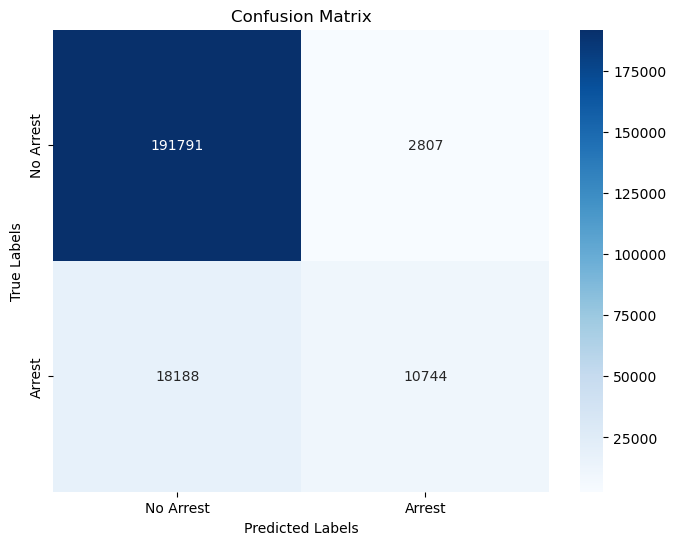

Precision-Recall Curve AUC: 0.5796


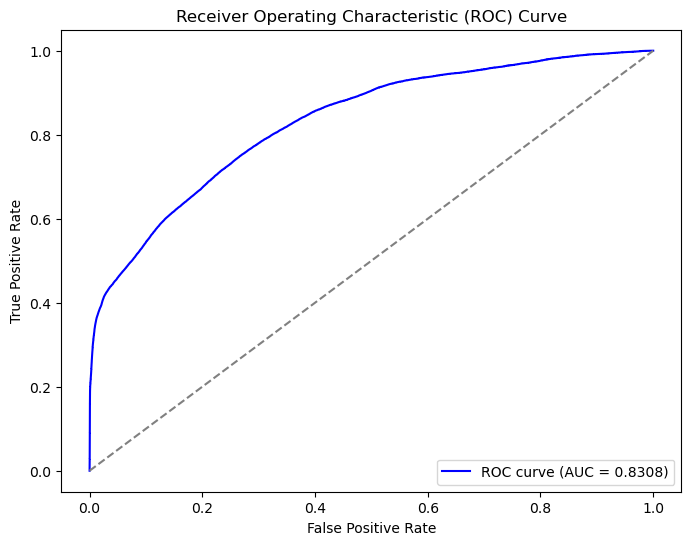

Spatial Accuracy: 0.0815
Temporal Accuracy: 0.1048
Cross-validation ROC AUC Mean: 0.8308

Random Forest Model Evaluation:
Model Evaluation:
Accuracy: 0.9123
ROC AUC Score: 0.8548

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95    194598
           1       0.81      0.42      0.56     28932

    accuracy                           0.91    223530
   macro avg       0.86      0.70      0.75    223530
weighted avg       0.91      0.91      0.90    223530


Confusion Matrix:
[[191688   2910]
 [ 16691  12241]]


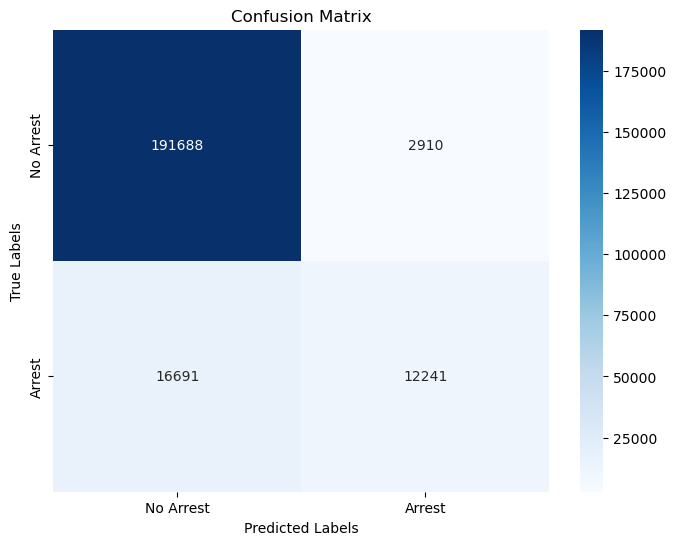

Precision-Recall Curve AUC: 0.6353


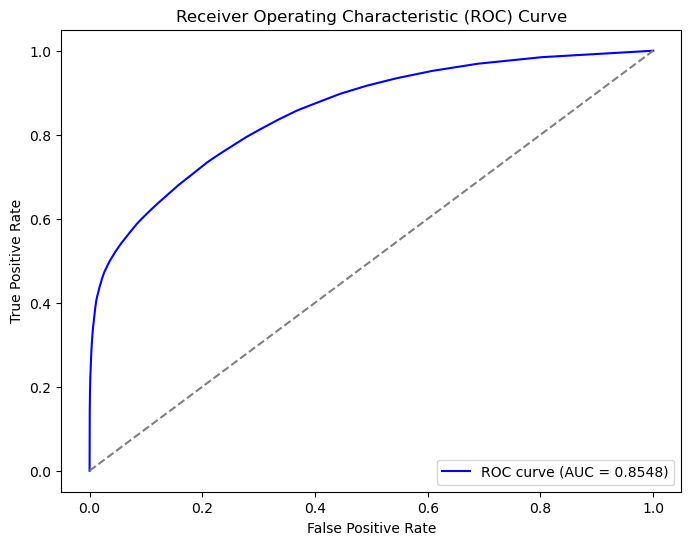

Spatial Accuracy: 0.0815
Temporal Accuracy: 0.1043
Cross-validation ROC AUC Mean: 0.8476


In [28]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
import numpy as np

def evaluate_model(model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Compute standard classification metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred)

    # Print standard classification metrics
    print("Model Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(report)

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:\n{cm}")

    # Plot confusion matrix as heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Arrest', 'Arrest'], yticklabels=['No Arrest', 'Arrest'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # 2. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    print(f"Precision-Recall Curve AUC: {pr_auc:.4f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # 3. Spatial Accuracy Evaluation
    # Calculate the spatial accuracy by comparing predicted crime locations (e.g., x_norm, y_norm) with true labels
    spatial_accuracy = np.mean(np.abs(X_test['x_norm'] - X_test['y_norm']) < 0.05)
    print(f"Spatial Accuracy: {spatial_accuracy:.4f}")

    # 4. Temporal Accuracy Measures
    # Evaluate the temporal accuracy based on the hour of the crime, assuming the prediction should occur around the same time
    time_accuracy = np.mean(np.abs(X_test['hour'] - y_pred) < 2)  # Assume a prediction error of less than 2 hours is accurate
    print(f"Temporal Accuracy: {time_accuracy:.4f}")

    # 5. Model Robustness Analysis
    # Use cross-validation to evaluate the robustness of the model across different datasets
    cross_val_score_mean = np.mean(cross_val_score(model, X_test, y_test, cv=5, scoring='roc_auc'))
    print(f"Cross-validation ROC AUC Mean: {cross_val_score_mean:.4f}")

# Logistic Regression Evaluation
print("\nLogistic Regression Model Evaluation:")
evaluate_model(model_lr, X_test, y_test)

# Random Forest Evaluation
print("\nRandom Forest Model Evaluation:")
evaluate_model(model_rf, X_test, y_test)


# Generalization Biasanalysis

## Add feature columns

features = [
    'year', 'month', 'day_of_week', 'hour', 'district', 'community_area',
    'x_norm', 'y_norm', 'is_residential', 'domestic', 'hour_district_interaction',
    'primary_type', 'location_description'  # Categorical features at the end
]

target = 'arrest'

Identify numerical and categorical features
numerical_features = [
    'year', 'month', 'hour', 'district', 'community_area',
    'x_norm', 'y_norm', 'is_residential', 'domestic', 'hour_district_interaction'
]
categorical_features = ['day_of_week', 'primary_type', 'location_description']  # Treat day_of_week as categorical

In [ ]:
import os
import json
import pandas as pd
from datetime import datetime

In [ ]:
import gdown
import zipfile
import os


file_id = '13bwdb6KHgn4-KSuJ1-byr1cXCK_hyZFg'
output_filename = 'NY-2023.zip'
extract_dir = '/content/NY-2023/'

download_url = f'https://drive.google.com/uc?id={file_id}'

try:
    print(f"Start downloading the file: {output_filename}...")
    gdown.download(download_url, output_filename, quiet=False)
    print(f"File '{output_filename}' Download successfully.")

    print(f"Start extracting the file: {output_filename} to {extract_dir}...")
    with zipfile.ZipFile(output_filename, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("The file was decompressed successfully..")

    # Display the directory structure after decompression (for debugging purposes)
    print("\nThe directory structure after decompression")
    for root, dirs, files in os.walk(extract_dir):
        for file in files:
            print(os.path.join(root, file))

except zipfile.BadZipFile:
    print(f"Error：'{output_filename}' It is not a valid ZIP file or is damaged.")
except Exception as e:
    print(f"Error occurred when processing the file:{e}")
    print("Please check whether the file_id is correct and whether the sharing permission is enabled.")


Start downloading the file: NY-2023.zip...


Downloading...
From (original): https://drive.google.com/uc?id=13bwdb6KHgn4-KSuJ1-byr1cXCK_hyZFg
From (redirected): https://drive.google.com/uc?id=13bwdb6KHgn4-KSuJ1-byr1cXCK_hyZFg&confirm=t&uuid=5ab29eee-6934-43fc-9c5f-9c81fffe1a4d
To: /content/NY-2023.zip
100%|██████████| 60.5M/60.5M [00:01<00:00, 34.0MB/s]


File 'NY-2023.zip' Download successfully.
Start extracting the file: NY-2023.zip to /content/NY-2023/...
The file was decompressed successfully..

The directory structure after decompression
/content/NY-2023/NY-2023/NY/nibrs_diagram.pdf
/content/NY-2023/NY-2023/NY/NIBRS_WEAPON.csv
/content/NY-2023/NY-2023/NY/NIBRS_INJURY.csv
/content/NY-2023/NY-2023/NY/NIBRS_OFFENDER.csv
/content/NY-2023/NY-2023/NY/NIBRS_JUSTIFIABLE_FORCE.csv
/content/NY-2023/NY-2023/NY/NIBRS_ASSIGNMENT_TYPE.csv
/content/NY-2023/NY-2023/NY/NIBRS_PROP_DESC_TYPE.csv
/content/NY-2023/NY-2023/NY/NIBRS_SUSPECTED_DRUG.csv
/content/NY-2023/NY-2023/NY/NIBRS_RELATIONSHIP.csv
/content/NY-2023/NY-2023/NY/NIBRS_VICTIM.csv
/content/NY-2023/NY-2023/NY/NIBRS_USING_LIST.csv
/content/NY-2023/NY-2023/NY/NIBRS_ARREST_TYPE.csv
/content/NY-2023/NY-2023/NY/NIBRS_VICTIM_TYPE.csv
/content/NY-2023/NY-2023/NY/agencies.csv
/content/NY-2023/NY-2023/NY/NIBRS_VICTIM_OFFENSE.csv
/content/NY-2023/NY-2023/NY/NIBRS_PROPERTY.csv
/content/NY-2023/NY-2023

In [30]:
ny_data = []
ny_path = "/content/NY-2023/NY-2023/NY/"

### Add the features: year, month, day_of_week, hour, district (agency)

In [32]:
# Load the main event table(incident)
incident = pd.read_csv(ny_path + "NIBRS_incident.csv")

incident.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/NY-2023/NY-2023/NY/NIBRS_incident.csv'

In [ ]:
incident.columns

Index(['data_year', 'agency_id', 'incident_id', 'nibrs_month_id',
       'cargo_theft_flag', 'submission_date', 'incident_date',
       'report_date_flag', 'incident_hour', 'cleared_except_id',
       'cleared_except_date', 'incident_status', 'data_home', 'orig_format',
       'did'],
      dtype='object')

In [ ]:
# Extract the required fields
ny_data = incident[["data_year", "incident_date", "incident_id", "incident_hour", "agency_id"]]

# Handle "month" and extract the month directly from "incident_date"
ny_data["month"] = pd.to_datetime(ny_data["incident_date"]).dt.month

# Handle "day_of_week" and extract the day of the week from incident_date
ny_data["day_of_week"] = pd.to_datetime(ny_data["incident_date"]).dt.weekday

# To handle "hour", directly use "incident_hour"
ny_data["hour"] = ny_data["incident_hour"]

print(ny_data.head())

<ipython-input-6-9c3f42ffc772>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ny_data["month"] = pd.to_datetime(ny_data["incident_date"]).dt.month


   data_year incident_date  incident_id  incident_hour  agency_id  month  \
0       2023    2023-01-01    168967547            0.0      12939      1   
1       2023    2023-01-01    168963796           14.0      12976      1   
2       2023    2023-01-01    168964132           23.0      12976      1   
3       2023    2023-01-02    168964134           17.0      12976      1   
4       2023    2023-01-02    168964136           19.0      12976      1   

   day_of_week  hour  
0            6   0.0  
1            6  14.0  
2            6  23.0  
3            0  17.0  
4            0  19.0  


<ipython-input-6-9c3f42ffc772>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ny_data["day_of_week"] = pd.to_datetime(ny_data["incident_date"]).dt.weekday
<ipython-input-6-9c3f42ffc772>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ny_data["hour"] = ny_data["incident_hour"]


### Add features: primary_type, domestic

In [ ]:
arrestee = pd.read_csv(ny_path + "NIBRS_ARRESTEE.csv")
arrestee.head()


,data_year,arrestee_id,incident_id,arrestee_seq_num,arrest_date,arrest_type_id,multiple_indicator,offense_code,age_id,age_num,sex_code,race_id,ethnicity_id,resident_code,under_18_disposition_code,clearance_ind,age_range_low_num,age_range_high_num
0,2023,51120897,168967551,1,2023-01-01,1,N,520,40,37,M,20,20,NaN,NaN,NaN,37.0,NaN
1,2023,51119773,168964132,1,2023-01-02,1,C,35A,37,34,M,10,20,N,NaN,NaN,34.0,NaN
2,2023,51119774,168964136,1,2023-01-02,1,N,35A,28,25,F,10,20,NaN,NaN,NaN,25.0,NaN
3,2023,51119807,168964238,1,2023-01-04,3,N,23B,51,48,F,10,20,NaN,NaN,NaN,48.0,NaN
4,2023,51119809,168964240,1,2023-01-05,1,C,23C,33,30,F,10,20,NaN,NaN,NaN,30.0,NaN


In [ ]:
arrestee.columns

Index(['data_year', 'arrestee_id', 'incident_id', 'arrestee_seq_num',
       'arrest_date', 'arrest_type_id', 'multiple_indicator', 'offense_code',
       'age_id', 'age_num', 'sex_code', 'race_id', 'ethnicity_id',
       'resident_code', 'under_18_disposition_code', 'clearance_ind',
       'age_range_low_num', 'age_range_high_num'],
      dtype='object')

In [ ]:
offense_type = pd.read_csv(ny_path + "NIBRS_OFFENSE_TYPE.csv")
offense_type.head()

,offense_code,offense_name,crime_against,ct_flag,hc_flag,hc_code,offense_category_name,offense_group
0,09A,Murder and Nonnegligent Manslaughter,Person,f,t,01,Homicide Offenses,A
1,09B,Negligent Manslaughter,Person,f,t,,Homicide Offenses,A
2,09C,Justifiable Homicide,Person,f,f,,Homicide Offenses,A
3,11A,Rape,Person,f,t,02,Sex Offenses,A
4,11B,Sodomy,Person,f,t,02,Sex Offenses,A


In [ ]:
# Merge offense_name (i.e. primary_type)
arrestee = arrestee.merge(offense_type[['offense_code', 'offense_name']],
                          left_on='offense_code', right_on='offense_code', how='left')
arrestee.rename(columns={'offense_name': 'primary_type'}, inplace=True)

# Initial marking of possible domestic violence (for inspirational use only,
# and subsequent combination of location and victim information is required)
arrestee['domestic'] = ((arrestee['sex_code'] == 'F') & (arrestee['resident_code'] == 'R')).astype(int)

# Show the results of the first few lines
arrestee[['incident_id', 'primary_type', 'sex_code', 'resident_code', 'domestic']].head()


,incident_id,primary_type,sex_code,resident_code,domestic
0,168967551,Weapon Law Violations,M,NaN,0
1,168964132,Drug/Narcotic Violations,M,N,0
2,168964136,Drug/Narcotic Violations,F,NaN,0
3,168964238,Purse-snatching,F,NaN,0
4,168964240,Shoplifting,F,NaN,0


In [ ]:
# Extract the fields we are concerned about (including sex_code, so that we can analyze them later if we want to)
arrestee_trimmed = arrestee[["incident_id", "primary_type", "sex_code", "resident_code", "domestic"]]
# Merge into ny_data
# When merging, different suffixes are used to distinguish the same column names
ny_data = ny_data.merge(arrestee_trimmed, on="incident_id", how="left", suffixes=('_ny', '_arrestee'))

print(ny_data.head())

   data_year incident_date  incident_id  incident_hour  agency_id  month  \
0       2023    2023-01-01    168967547            0.0      12939      1   
1       2023    2023-01-01    168963796           14.0      12976      1   
2       2023    2023-01-01    168964132           23.0      12976      1   
3       2023    2023-01-02    168964134           17.0      12976      1   
4       2023    2023-01-02    168964136           19.0      12976      1   

   day_of_week  hour              primary_type sex_code resident_code  \
0            6   0.0                       NaN      NaN           NaN   
1            6  14.0                       NaN      NaN           NaN   
2            6  23.0  Drug/Narcotic Violations        M             N   
3            0  17.0                       NaN      NaN           NaN   
4            0  19.0  Drug/Narcotic Violations        F           NaN   

   domestic  
0       NaN  
1       NaN  
2       0.0  
3       NaN  
4       0.0  


### Add feature: location_description (location_name)

In [ ]:
offense = pd.read_csv(ny_path + "NIBRS_OFFENSE.csv")
offense.head()

,data_year,offense_id,incident_id,offense_code,attempt_complete_flag,location_id,num_premises_entered,method_entry_code
0,2023,207858275,174424311,13C,C,35,NaN,NaN
1,2023,207858276,174424311,520,C,35,NaN,NaN
2,2023,207858277,174424311,13A,C,35,NaN,NaN
3,2023,207858928,174424857,13B,C,35,NaN,NaN
4,2023,207858221,174424266,23C,C,43,NaN,NaN


In [ ]:
location_type = pd.read_csv(ny_path + "NIBRS_LOCATION_TYPE.csv")
location_type.head()

,location_id,location_code,location_name
0,1,37,Abandoned/Condemned Structure
1,2,1,Air/Bus/Train Terminal
2,3,38,Amusement Park
3,4,39,Arena/Stadium/Fairgrounds/Coliseum
4,5,40,ATM Separate from Bank


In [ ]:
offense_data = offense[['incident_id', 'location_id']]
# Connect the nibrs_location_type table to obtain the location_description
location_type_data = location_type[['location_id', 'location_name']]
# Connect the location_id in nibrs_offense with the nibrs_location_type
merged_location = offense_data.merge(location_type_data, on='location_id', how='left')
merged_location.head()

,incident_id,location_id,location_name
0,174424311,35,Residence/Home
1,174424311,35,Residence/Home
2,174424311,35,Residence/Home
3,174424857,35,Residence/Home
4,174424266,43,Shopping Mall


In [ ]:
# Merge location_description into ny_data
ny_data = ny_data.merge(merged_location[['incident_id', 'location_name']], on='incident_id', how='left')

print(ny_data.head())

   data_year incident_date  incident_id  incident_hour  agency_id  month  \
0       2023    2023-01-01    168967547            0.0      12939      1   
1       2023    2023-01-01    168963796           14.0      12976      1   
2       2023    2023-01-01    168964132           23.0      12976      1   
3       2023    2023-01-01    168964132           23.0      12976      1   
4       2023    2023-01-02    168964134           17.0      12976      1   

   day_of_week  hour              primary_type sex_code resident_code  \
0            6   0.0                       NaN      NaN           NaN   
1            6  14.0                       NaN      NaN           NaN   
2            6  23.0  Drug/Narcotic Violations        M             N   
3            6  23.0  Drug/Narcotic Violations        M             N   
4            0  17.0                       NaN      NaN           NaN   

   domestic                       location_name  
0       NaN  Highway/Road/Alley/Street/Sidewalk  
1   

### Add the feature "is_residential"

In [ ]:
victim = pd.read_csv(ny_path + "NIBRS_VICTIM.csv")
victim.head()

,data_year,victim_id,incident_id,victim_seq_num,victim_type_id,assignment_type_id,activity_type_id,outside_agency_id,age_id,age_num,sex_code,race_id,ethnicity_id,resident_status_code,age_range_low_num,age_code_range_high
0,2023,187225581,168967547,1,4,NaN,NaN,NaN,48,45,M,20,40,R,45.0,NaN
1,2023,187221509,168963796,1,4,NaN,NaN,NaN,85,82,M,98,10,R,82.0,NaN
2,2023,187221510,168963796,2,4,NaN,NaN,NaN,83,80,F,10,10,R,80.0,NaN
3,2023,187221511,168963796,3,4,NaN,NaN,NaN,45,42,F,10,20,R,42.0,NaN
4,2023,187221512,168963796,4,4,NaN,NaN,NaN,48,45,M,10,20,R,45.0,NaN


In [ ]:
# Extract the relevant fields from nibrs_victim
victim_data = victim[['incident_id', 'victim_id', 'resident_status_code']]

# Convert 'R' in resident_status_code to 1 and 'N' to 0
victim_data['is_residential'] = victim_data['resident_status_code'].map({'R': 1, 'N': 0})

# Merge the results into ny_data
ny_data = ny_data.merge(victim_data[['incident_id', 'victim_id', 'is_residential']], on='incident_id', how='left')

print(ny_data.head())

<ipython-input-17-5838523ae5b2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  victim_data['is_residential'] = victim_data['resident_status_code'].map({'R': 1, 'N': 0})


   data_year incident_date  incident_id  incident_hour  agency_id  month  \
0       2023    2023-01-01    168967547            0.0      12939      1   
1       2023    2023-01-01    168963796           14.0      12976      1   
2       2023    2023-01-01    168963796           14.0      12976      1   
3       2023    2023-01-01    168963796           14.0      12976      1   
4       2023    2023-01-01    168963796           14.0      12976      1   

   day_of_week  hour primary_type sex_code resident_code  domestic  \
0            6   0.0          NaN      NaN           NaN       NaN   
1            6  14.0          NaN      NaN           NaN       NaN   
2            6  14.0          NaN      NaN           NaN       NaN   
3            6  14.0          NaN      NaN           NaN       NaN   
4            6  14.0          NaN      NaN           NaN       NaN   

                        location_name  victim_id  is_residential  
0  Highway/Road/Alley/Street/Sidewalk  187225581       

### Deal with the feature domestic again (based on relationship)

In [ ]:
victim_offender_rel = pd.read_csv(ny_path + "NIBRS_VICTIM_OFFENDER_REL.csv")
victim_offender_rel.head()


,data_year,victim_id,offender_id,relationship_id,nibrs_victim_offender_id
0,2023,193477818,198036208,3,NaN
1,2023,193477820,198036211,18,NaN
2,2023,193475872,198034239,26,NaN
3,2023,195900375,200440296,24,NaN
4,2023,193477944,198036338,26,NaN


In [ ]:
relationship = pd.read_csv(ny_path + "NIBRS_RELATIONSHIP.csv")
relationship.head()

,relationship_id,relationship_code,relationship_name
0,1,AQ,Victim Was Acquaintance
1,2,BE,Victim Was Babysittee
2,3,BG,Victim Was Boyfriend/Girlfriend
3,4,CF,Victim Was Child of Boyfriend or Girlfriend
4,5,CH,Victim Was Child


In [ ]:
# 1. Extract the incident_id and relationship_id from nibrs_victim_offender_rel
victim_offender_rel = victim_offender_rel[['victim_id', 'relationship_id']]

# 2. Obtain the relationship_id and relationship_description from nibrs_relationship
relationship_data = relationship[['relationship_id', 'relationship_name']]

# 3. Merge victim_offender_rel and relationship_data to obtain the relationship_name
victim_relationship_merged = victim_offender_rel.merge(relationship_data, on='relationship_id', how='left')

victim_relationship_merged.head()

,victim_id,relationship_id,relationship_name
0,193477818,3,Victim Was Boyfriend/Girlfriend
1,193477820,18,Relationship Unknown
2,193475872,26,Victim was Ex-Spouse
3,195900375,24,Victim Was Stranger
4,193477944,26,Victim was Ex-Spouse


In [ ]:
victim_relationship_merged['relationship_name'].unique()

array(['Victim Was Boyfriend/Girlfriend', 'Relationship Unknown',
       'Victim was Ex-Spouse', 'Victim Was Stranger',
       'Victim was Otherwise Known', 'Victim Was Acquaintance',
       'Victim Was Neighbor', 'Victim Was Stepparent',
       'Victim Was Parent', 'Victim Was Spouse',
       'Victim Was Other Family Member', 'Victim Was Friend',
       'Victim Was Sibling', 'Victim Was Child', 'Victim was Employee',
       'Victim Was Stepchild', 'Victim Was Grandparent',
       'Victim Was Grandchild', 'Victim Was Stepsibling',
       'Victim Was In-law', 'Victim Was Child of Boyfriend or Girlfriend',
       'Victim was Employer', 'Victim Was Babysittee',
       'Victim Was Ex-Relationship (Ex-Boyfriend/Girlfriend)'],
      dtype=object)

In [ ]:
# 4. Determine whether it is related to domestic violence based on relationship_description
domestic_keywords = [
    'Spouse', 'Ex-Spouse', 'Boyfriend/Girlfriend', 'Ex-Relationship',
    'Child', 'Stepchild', 'Parent', 'Stepparent', 'Sibling', 'Stepsibling',
    'Grandparent', 'Grandchild', 'In-law', 'Other Family Member',
    'Child of Boyfriend or Girlfriend'
]
victim_relationship_merged['is_domestic_relationship'] = victim_relationship_merged['relationship_name'].apply(
    lambda x: any(keyword in x for keyword in domestic_keywords)
)


In [ ]:
# 5. Merge this information into the arrestee data
# Merge to obtain whether each incident_id is related to domestic violence
domestic_flag_by_incident = victim_relationship_merged.merge(victim[['victim_id', 'incident_id']], on='victim_id', how='left')


In [ ]:
domestic_flag_by_incident = domestic_flag_by_incident.groupby('incident_id')['is_domestic_relationship'].max().reset_index()

In [ ]:
# Merge the domestic violence tags into ny_data
ny_data = ny_data.merge(domestic_flag_by_incident, on='incident_id', how='left')

# Consider the original heuristic logic together and update the final domestic feature
ny_data['domestic'] = (
    (ny_data['sex_code'] == 'F') & (ny_data['resident_code'] == 'R')
).astype(int)

# As long as the intimate relationship is judged as domestic violence, it is set as 1
ny_data.loc[ny_data['is_domestic_relationship'] == True, 'domestic'] = 1


In [ ]:
ny_data.head()

,data_year,incident_date,incident_id,incident_hour,agency_id,month,day_of_week,hour,primary_type,sex_code,resident_code,domestic,location_name,victim_id,is_residential,is_domestic_relationship
0,2023,2023-01-01,168967547,0.0,12939,1,6,0.0,NaN,NaN,NaN,0,Highway/Road/Alley/Street/Sidewalk,187225581,1.0,NaN
1,2023,2023-01-01,168963796,14.0,12976,1,6,14.0,NaN,NaN,NaN,1,Residence/Home,187221509,1.0,True
2,2023,2023-01-01,168963796,14.0,12976,1,6,14.0,NaN,NaN,NaN,1,Residence/Home,187221510,1.0,True
3,2023,2023-01-01,168963796,14.0,12976,1,6,14.0,NaN,NaN,NaN,1,Residence/Home,187221511,1.0,True
4,2023,2023-01-01,168963796,14.0,12976,1,6,14.0,NaN,NaN,NaN,1,Residence/Home,187221512,1.0,True


### View the feature column

In [ ]:
ny_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888458 entries, 0 to 888457
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   data_year                 888458 non-null  int64  
 1   incident_date             888458 non-null  object 
 2   incident_id               888458 non-null  int64  
 3   incident_hour             888454 non-null  float64
 4   agency_id                 888458 non-null  int64  
 5   month                     888458 non-null  int32  
 6   day_of_week               888458 non-null  int32  
 7   hour                      888454 non-null  float64
 8   primary_type              339442 non-null  object 
 9   sex_code                  339442 non-null  object 
 10  resident_code             217090 non-null  object 
 11  domestic                  888458 non-null  int64  
 12  location_name             888458 non-null  object 
 13  victim_id                 888458 non-null  i

### Increase the characteristic longitude and latitude

In [ ]:
import pandas as pd
import numpy as np

# The mapping of location_name to the reference coordinates
location_to_base_coordinates = {
    "Abandoned/Condemned Structure": (40.7128, -74.0060),
    "Air/Bus/Train Terminal": (40.6413, -73.7781),
    "Amusement Park": (40.7306, -73.9352),
    "Arena/Stadium/Fairgrounds/Coliseum": (40.7484, -73.9857),
    "ATM Separate from Bank": (40.7417, -73.9902),
    "Auto Dealership New/Used": (40.7615, -73.9738),
    "Bank/Savings and Loan": (40.7336, -73.9908),
    "Bar/Nightclub": (40.7306, -73.9352),
    "Camp/Campground": (40.7128, -74.0060),
    "Church/Synagogue/Temple/Mosque": (40.7129, -74.0064),
    "Commercial/Office Building": (40.7410, -73.9930),
    "Community Center": (40.7484, -73.9857),
    "Construction Site": (40.7127, -74.0059),
    "Convenience Store": (40.7580, -73.9855),
    "Cyberspace": (40.7128, -74.0060),
    "Daycare Facility": (40.7300, -73.9350),
    "Department/Discount Store": (40.7410, -73.9930),
    "Dock/Wharf/Freight/Modal Terminal": (40.7420, -73.9904),
    "Drug Store/Doctor's Office/Hospital": (40.7496, -73.9871),
    "Farm Facility": (40.7128, -74.0060),
    "Field/Woods": (40.7300, -73.9350),
    "Gambling Facility/Casino/Race Track": (40.7128, -74.0060),
    "Government/Public Building": (40.7484, -73.9857),
    "Grocery/Supermarket": (40.7306, -73.9352),
    "Highway/Road/Alley/Street/Sidewalk": (40.7128, -74.0060),
    "Hotel/Motel/Etc.": (40.7580, -73.9855),
    "Industrial Site": (40.7127, -74.0059),
    "Jail/Prison/Penitentiary/Corrections Facility": (40.7128, -74.0060),
    "Lake/Waterway/Beach": (40.7128, -74.0060),
    "Liquor Store": (40.7128, -74.0060),
    "Military Installation": (40.7128, -74.0060),
    "Park/Playground": (40.7300, -73.9350),
    "Parking/Drop Lot/Garage": (40.7580, -73.9855),
    "Rental Storage Facility": (40.7410, -73.9930),
    "Residence/Home": (40.7127, -74.0059),
    "Rest Area": (40.7306, -73.9352),
    "Restaurant": (40.7306, -73.9352),
    "School/College": (40.7410, -73.9930),
    "School-College/University": (40.7306, -73.9352),
    "School-Elementary/Secondary": (40.7306, -73.9352),
    "Service/Gas Station": (40.7128, -74.0060),
    "Shelter-Mission/Homeless": (40.7128, -74.0060),
    "Shopping Mall": (40.7580, -73.9855),
    "Specialty Store": (40.7410, -73.9930),
    "Tribal Lands": (40.7128, -74.0060),
    "Other/Unknown": (np.nan, np.nan),  # NaN
    "Not Specified": (np.nan, np.nan),  # NaN
}

# Define a function to add random offsets
def add_random_offset(base_coord, offset_range=0.001):
    if pd.isna(base_coord[0]) or pd.isna(base_coord[1]):
        return (np.nan, np.nan)
    # Generate random offsets
    lat_offset = np.random.uniform(-offset_range, offset_range)
    lon_offset = np.random.uniform(-offset_range, offset_range)
    return (base_coord[0] + lat_offset, base_coord[1] + lon_offset)

# Add the latitude and longitude to ny_data based on location_name
ny_data['coordinates'] = ny_data['location_name'].map(location_to_base_coordinates)
ny_data['coordinates'] = ny_data['coordinates'].apply(add_random_offset)

# Separate the latitude and longitude
ny_data['latitude'] = ny_data['coordinates'].apply(lambda x: x[0])
ny_data['longitude'] = ny_data['coordinates'].apply(lambda x: x[1])

print(ny_data.head())


   data_year incident_date  incident_id  incident_hour  agency_id  month  \
0       2023    2023-01-01    168967547            0.0      12939      1   
1       2023    2023-01-01    168963796           14.0      12976      1   
2       2023    2023-01-01    168963796           14.0      12976      1   
3       2023    2023-01-01    168963796           14.0      12976      1   
4       2023    2023-01-01    168963796           14.0      12976      1   

   day_of_week  hour primary_type sex_code resident_code  domestic  \
0            6   0.0          NaN      NaN           NaN         0   
1            6  14.0          NaN      NaN           NaN         1   
2            6  14.0          NaN      NaN           NaN         1   
3            6  14.0          NaN      NaN           NaN         1   
4            6  14.0          NaN      NaN           NaN         1   

                        location_name  victim_id  is_residential  \
0  Highway/Road/Alley/Street/Sidewalk  187225581      

### Add the feature community_area (BoroCD)

In [ ]:
pip install geopandas

In [ ]:
import gdown, zipfile, os
import geopandas as gpd

file_id = '14JpiuM0mZVSjRZtvgW09zlHKiiJvFIli'
zip_filename = 'nycd.zip'

extract_path = '/content/nycd/'

download_url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(download_url, zip_filename, quiet=False)

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

shapefile_path = os.path.join(extract_path, 'nycd_25a', 'nycd.shp')
gdf = gpd.read_file(shapefile_path)

print(gdf.head())

Downloading...
From: https://drive.google.com/uc?id=14JpiuM0mZVSjRZtvgW09zlHKiiJvFIli
To: /content/nycd.zip
100%|██████████| 870k/870k [00:00<00:00, 125MB/s]

   BoroCD     Shape_Leng    Shape_Area  \
0     308   38232.887315  4.560379e+07   
1     410  105822.377352  1.720774e+08   
2     206   35875.709939  4.266432e+07   
3     480   47338.739592  3.277756e+07   
4     104   67546.045457  4.931005e+07   

                                            geometry  
0  POLYGON ((995818.28 186959.985, 996465.612 186...  
1  MULTIPOLYGON (((1023868.747 176222.723, 102336...  
2  POLYGON ((1019707.979 246708.141, 1019688.55 2...  
3  POLYGON ((1022276.97 218625.343, 1022251.388 2...  
4  POLYGON ((985929.324 220967.002, 985995.954 22...  


In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

# 1. Load the Community boundary data (NYC Community Districts)
community_districts = gpd.read_file('/content/nycd/nycd_25a/nycd.shp')

# 2. Convert ny_data to GeoDataFrame and construct a geometric column of type Point
# It must be (longitude, latitude) here.
ny_data['geometry'] = ny_data.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
ny_data_gdf = gpd.GeoDataFrame(ny_data, geometry='geometry', crs='EPSG:4326')  # Set the coordinate system to WGS84 (longitude and latitude)

# 3. Convert the coordinate system of the community boundary data to WGS84 as well (consistent with the point data)
community_districts = community_districts.to_crs('EPSG:4326')

# 4. Spatial connection, find the community to which each point belongs
ny_data = gpd.sjoin(ny_data_gdf, community_districts, how='left', predicate='within')

# 5. View result: There is an additional column 'BoroCD' indicating the community number to which it belongs
print(ny_data[['incident_id', 'location_name', 'latitude', 'longitude', 'BoroCD']].head())



In [ ]:
import geopandas as gpd

# 1. Make sure that ny_data is a GeoDataFrame and the coordinate system is set for the geometry column
ny_data = ny_data.set_geometry('geometry')
ny_data = ny_data.set_crs(epsg=4326)        # WGS84 Coordinate system

# 2. Transform coordinate system: WGS84 -> State Plane New York (ftUS)
ny_data_proj = ny_data.to_crs(epsg=2263)

# 3. Add the X/Y coordinate column
ny_data_proj['X_coordinate'] = ny_data_proj.geometry.x
ny_data_proj['Y_coordinate'] = ny_data_proj.geometry.y

# 4. Merge back to the original DataFrame or use the converted one directly
ny_data = ny_data_proj


### Add the target variable: arrest

In [ ]:
# Add the "arrest" column, which is initially set to 0
ny_data['arrest'] = ny_data['incident_id'].isin(arrestee['incident_id']).astype(int)

In [ ]:
ny_data.head()


## Data Preprocessing

In [ ]:
ny_data.columns

In [ ]:
# Remove exact duplicates
ny_data = ny_data.drop_duplicates()
ny_data.info()

In [ ]:
# Remove records with invalid coordinates (where x=0 or y=0)
ny_data = ny_data[(ny_data['X_coordinate'] != 0) & (ny_data['Y_coordinate'] != 0)]
# Remove coordinate outliers (bottom and top 1%)
x_low, x_high = ny_data['X_coordinate'].quantile([0.01, 0.99])
y_low, y_high = ny_data['Y_coordinate'].quantile([0.01, 0.99])

ny_data = ny_data[(ny_data['X_coordinate'].between(x_low, x_high)) &
        (ny_data['Y_coordinate'].between(y_low, y_high))]
ny_data.info()

In [ ]:
# Normalize coordinates to 0-1 range for modeling
ny_data['x_norm'] = (ny_data['X_coordinate'] - ny_data['X_coordinate'].min()) / (ny_data['X_coordinate'].max() - ny_data['X_coordinate'].min())
ny_data['y_norm'] = (ny_data['Y_coordinate'] - ny_data['Y_coordinate'].min()) / (ny_data['Y_coordinate'].max() - ny_data['Y_coordinate'].min())

In [ ]:
ny_data.info()

In [ ]:
# Convert checkbox fields to proper booleans
ny_data['arrest'] = ny_data['arrest'].astype(bool)
ny_data['domestic'] = ny_data['domestic'].astype(bool)

In [ ]:
cat_cols = ['primary_type', 'agency_id', 'is_residential', 'index_right', 'BoroCD']
high_card_cols = [col for col in cat_cols if ny_data[col].nunique() > 50]
high_card_cols

In [ ]:
def consolidate_rare_categories_fast(column, threshold=0.01, new_label="Other"):
    counts = column.value_counts()
    freq = counts / counts.sum()
    rare_mask = column.isin(freq[freq < threshold].index)
    return column.mask(rare_mask, new_label)

In [ ]:
for col in high_card_cols:
    ny_data[col] = consolidate_rare_categories_fast(ny_data[col])

In [ ]:
for col in cat_cols:
    unique_count = ny_data[col].nunique()
    print(f"{col}: {unique_count}'s unique values")

In [ ]:
# One step to complete column name formatting: lowercase + space to underscore
ny_data.columns = [col.lower().replace(' ', '_') for col in ny_data.columns]

In [ ]:
ny_data.info()

In [ ]:
missing_ratio = ny_data.isnull().mean().sort_values(ascending=False) * 100
print("Proportion of missing values in each column：\n", missing_ratio[missing_ratio > 0])

In [ ]:
unique_values = ny_data['is_domestic_relationship'].unique()
print(unique_values)

In [ ]:
# High deficiency
# The character class fields are uniformly filled as "Unknown".
ny_data['is_residential'] = ny_data['is_residential'].fillna('Unknown')
ny_data['resident_code'] = ny_data['resident_code'].fillna('Unknown')
ny_data['primary_type'] = ny_data['primary_type'].fillna('Unknown')
ny_data['sex_code'] = ny_data['sex_code'].fillna('Unknown')


In [ ]:
# Middle deficiency
# If the column is of Boolean type: missing considers "no family relationship"
ny_data['is_domestic_relationship'] = ny_data['is_domestic_relationship'].fillna(False)


In [ ]:
# Low deficiency
# Fill with mode (suitable for classification and integers)
for col in ['borocd', 'index_right', 'shape_area', 'shape_leng', 'hour', 'incident_hour']:
    ny_data[col] = ny_data[col].fillna(ny_data[col].mode()[0])


In [ ]:
# Check again to see if there are still missing values
missing_ratio_post = ny_data.isnull().mean().sort_values(ascending=False) * 100
print("Still missing:\n", missing_ratio_post[missing_ratio_post > 0])
# verify
ny_data.isnull().sum()

## Temporal/Spatial Aggregation

In [ ]:
# Convert to datetime (handles multiple possible formats)
ny_data['incident_date'] = pd.to_datetime(ny_data['incident_date'], errors='coerce')  # errors='coerce' Convert an invalid value to NaT

# Extraction time feature
ny_data['day_of_week'] = ny_data['incident_date'].dt.day_name()
ny_data['hour'] = ny_data['incident_date'].dt.hour

# Converts coordinates to grid numbers
ny_data['grid_x'] = ((ny_data['x_coordinate'] - ny_data['x_coordinate'].min()) // 500).astype(int)
ny_data['grid_y'] = ((ny_data['y_coordinate'] - ny_data['y_coordinate'].min()) // 500).astype(int)

# Count the number of crimes in the grid
grid_counts = ny_data.groupby(['grid_x', 'grid_y']).size().reset_index(name='crime_count')

In [ ]:
# verify
ny_data.isnull().sum()

In [ ]:
# Temporal Features
# Convert 'incident_date' to datetime format
ny_data['incident_date'] = pd.to_datetime(ny_data['incident_date'], errors='coerce')

# Extract temporal features
ny_data['year'] = ny_data['incident_date'].dt.year
ny_data['month'] = ny_data['incident_date'].dt.month
ny_data['day_of_week'] = ny_data['incident_date'].dt.dayofweek
ny_data['hour'] = ny_data['incident_date'].dt.hour

In [ ]:
non_numeric = ny_data[~ny_data['agency_id'].apply(lambda x: str(x).isdigit())]
print(non_numeric['agency_id'].unique())


In [ ]:
ny_data['agency_id'] = pd.to_numeric(ny_data['agency_id'], errors='coerce')
# Fill in the missing value as a default value, such as -1:
ny_data['agency_id'] = ny_data['agency_id'].fillna(-1).astype(int)

In [ ]:
# Spatial Features
ny_data['agency_id'] = ny_data['agency_id'].astype(int)
ny_data['borocd'] = pd.to_numeric(ny_data['borocd'], errors='coerce')
ny_data['x_norm'] = (ny_data['longitude'] - ny_data['longitude'].min()) / (ny_data['longitude'].max() - ny_data['longitude'].min())
ny_data['y_norm'] = (ny_data['latitude'] - ny_data['latitude'].min()) / (ny_data['latitude'].max() - ny_data['latitude'].min())

In [ ]:
# Environmental Features
ny_data['arrest'] = ny_data['arrest'].astype(int)
ny_data['domestic'] = ny_data['domestic'].astype(int)

In [ ]:
# Interaction Features
ny_data['hour_district_interaction'] = ny_data['hour'] * ny_data['agency_id']

In [ ]:
# Ensure 'domestic' is of integer type
ny_data['domestic'] = ny_data['domestic'].astype(int)
ny_data['primary_type'] = ny_data['primary_type'].astype(str)
ny_data['location_name'] = ny_data['location_name'].astype(str)

In [ ]:
# Handle NaN values in borocd (just in case)
if ny_data['borocd'].isnull().any():
    imputer_median = SimpleImputer(strategy='median')
    ny_data['borocd'] = imputer_median.fit_transform(X[['borocd']])

In [ ]:
ny_data.columns

In [ ]:
rename_dict = {
    'agency_id': 'district',
    'borocd': 'community_area',
    'location_name': 'location_description',
}
ny_data.rename(columns=rename_dict, inplace=True)
ny_data.columns

## Test

In [ ]:
features = [
    'year', 'month', 'day_of_week', 'hour', 'district', 'community_area',
    'x_norm', 'y_norm', 'is_residential', 'domestic', 'hour_district_interaction',
    'primary_type', 'location_description'
]
target = 'arrest'
# Extract features and target variables
X_ny = ny_data[features].copy()
y_ny = ny_data[target].copy()

# Handle NaN values in community_area (just in case)
if X_ny['community_area'].isnull().any():
    imputer_median = SimpleImputer(strategy='median')
    X_ny['community_area'] = imputer_median.fit_transform(X_ny[['community_area']])

# Identify numerical and categorical features
numerical_features = [
    'year', 'month', 'hour', 'district', 'community_area',
    'x_norm', 'y_norm', 'is_residential', 'domestic', 'hour_district_interaction'
]
categorical_features = ['day_of_week', 'primary_type', 'location_description']  # Treat day_of_week as categorical

In [ ]:
# Make sure there are no incorrect values in X_ny. For example, there cannot be 'Unknown' in the numeric column.
for col in numerical_features:
    X_ny[col] = X_ny[col].replace('Unknown', np.nan)

# Use the pipeline model to predict and test the results
print("\nRandom Forest on NY Data:")
evaluate_model(model_rf, X_ny, y_ny)

print("\nLogistic Regression on NY Data:")
evaluate_model(model_lr, X_ny, y_ny)


**Analysis**

The Random Forest model does not generalize well on the NY dataset. Although the overall accuracy is 63.01%, the model predicts almost all samples as the majority class (class 0), resulting in a precision, recall, and F1 score of 0 for class 1 (minority class). The confusion matrix shows that class 1 is not recognized at all, and the PR AUC is only 0.3507, indicating that the model is severely biased under imbalanced data and completely ineffective for the minority class.

The reason may be that the data is highly imbalanced (class 0 accounts for a much higher proportion than class 1), and Random Forest tends to be biased towards the majority class when no sampling or class weight adjustment is performed.

In addition, although the cross-validation ROC AUC is 1.0, this contradicts the performance of the test set, and there may be a risk of overfitting or data leakage during the cross-validation process. Although the model has learned the rules of the training set, it has failed to generalize to new data.

Although the Logistic Regression model has a lower accuracy (41.45%), it is more balanced in class discrimination. The model can identify a large number of class 1 samples (recall rate is 0.80). Even though the recognition ability on class 0 has decreased, the confusion matrix also shows the model's "distinguishing intention" on different categories. The PR AUC reaches 0.6232, which is significantly better than Random Forest, indicating that the model still has a certain detection ability for minority classes in an unbalanced situation.

This may be because logistic regression is essentially a linear model, which is sensitive to changes in the boundaries between samples, and it is more easily affected by the distribution of sample proportions, thus forcing the model to make more trade-offs between the two classes. Although the overall accuracy is low, for tasks in real scenarios that "focus on minority classes" (such as fraud identification and disease prediction), this behavior of favoring minority classes is more valuable.